In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from Clustering import Clustering
from DataNoiseAdder import DataNoiseAdder
from DatasetCorruptor import DatasetCorruptor
from DecisionTreeEnsemble import DecisionTreeEnsemble
from SyntheticDataGenerator import SyntheticDataGenerator
from EnsembleDiversity import EnsembleDiversity
from EnsembleMetrics import EnsembleMetrics

from utils import get_dataset, get_ensemble_preds_from_models, get_precision_recall_auc, auprc_threshs
from utils import plot_precision_recall, plot_aroc_at_curve, fitness_scatter

### Experiment Args

In [2]:
args = {}
args['ntrls'] = 10
args['ensemble_size'] = 100
args['dataset_path'] = "/Users/scottmerrill/Documents/UNC/Research/OOD-Ensembles/datasets"
args['dataset_name'] = 'heloc_tf' 

# Decision Tree/Model Pool Params
args['num_classifiers'] = 1000
args['feature_fraction'] = 0.5
args['data_fraction'] = 0.8
args['max_depth'] = 10
args['min_samples_leaf'] = 5
args['random_state'] = 1

AUCTHRESHS = np.array([0.1, 0.2, 0.3, 0.4, 1. ])

In [ ]:
x_train, y_train, x_val_id, y_val_id, x_val_ood, y_val_ood = get_dataset(args['dataset_path'] , args['dataset_name'])
num_features = x_train.shape[1]

### Building and Training Model Pool

In [4]:
model_pool = DecisionTreeEnsemble(args['num_classifiers'], 
                                  args['feature_fraction'],
                                  args['data_fraction'],
                                  args['max_depth'],
                                  args['min_samples_leaf'],
                                  args['random_state'])

# train model pool
model_pool.train(x_train, y_train)

### Caching Model Pool Predictions

In [6]:
model_pool_preds = model_pool.predict(x_val_ood)
model_pool_pred_probs = model_pool.predict_proba(x_val_ood)
mp_precision, mp_recall, mp_auc = get_precision_recall_auc(model_pool_pred_probs, y_val_ood, AUCTHRESHS)

/Users/scottmerrill/Desktop/OOD_Pruning/utils.py:182: RuntimeWarning: invalid value encountered in scalar divide
  precision = [tp/(tp+fp) for tp, fp in zip(tps, fps)]


### Caching Individual Model Predictions

In [ ]:
model_pool.train_preds = model_pool.get_individual_predictions(x_train)
model_pool.train_pred_probs = model_pool.get_individual_probabilities(x_train)

model_pool.val_id_preds = model_pool.get_individual_predictions(x_val_id)
model_pool.val_id_pred_probs = model_pool.get_individual_probabilities(x_val_id)

model_pool.val_ood_preds = model_pool.get_individual_predictions(x_val_ood)
model_pool.val_ood_pred_probs = model_pool.get_individual_probabilities(x_val_ood)

### Random Search Loop

In [8]:
precisions_df = pd.DataFrame()
recalls_df = pd.DataFrame()
aucs_df = pd.DataFrame()
fitness_df = pd.DataFrame()

for trial in range(args['ntrls']):
    print(f"Starting Trial {trial}")

    indices = np.random.choice(model_pool.num_classifiers, size=args['ensemble_size'], replace=True)

    # id val preds of sub-ensemble
    id_preds, id_pred_probs = get_ensemble_preds_from_models(model_pool.val_id_pred_probs[indices])
    metrics = EnsembleMetrics(y_val_id, id_preds, id_pred_probs[:,1])

    # ood preds of sub-ensemble
    ood_preds, ood_pred_probs = get_ensemble_preds_from_models(model_pool.val_ood_pred_probs[indices])

        
    
    # save dfs
    precision, recall, auc = get_precision_recall_auc(ood_pred_probs, y_val_ood, AUCTHRESHS)

    recalls_df = pd.concat([recalls_df, pd.DataFrame(recall)], axis=1)
    precisions_df = pd.concat([precisions_df, pd.DataFrame(precision)], axis=1)
    aucs_df = pd.concat([aucs_df, pd.DataFrame(auc)], axis=1)

    tmp = {'generation':trial,
          'ensemble_files':','.join(str(x) for x in indices),
           'val_acc':metrics.accuracy(),
           'val_auc':metrics.auc(),
           'val_prec':metrics.precision(),
           'val_rec':metrics.recall(),
           'val_f1':metrics.f1(),
           'val_mae':metrics.mean_absolute_error(),
           'val_mse':metrics.mean_squared_error(),
           'val_logloss':metrics.log_loss()}
    fitness_df = pd.concat([fitness_df, pd.DataFrame([tmp])])
    
    #precisions_df.to_csv(save_path+'/precisions_df.csv', index=False)
    #recalls_df.to_csv(save_path+'/recalls_df.csv', index=False)
    #aucs_df.to_csv(save_path+'/aucs_df.csv', index=False)

Starting Trial 0
Starting Trial 1
Starting Trial 2
Starting Trial 3
Starting Trial 4
Starting Trial 5
Starting Trial 6
Starting Trial 7
Starting Trial 8
Starting Trial 9


### Plot Results

In [9]:
fitness_df = fitness_df.reset_index(drop=True)
best_fitness_index = {i+1:index for i,index in enumerate(fitness_df.nlargest(3, 'val_auc').index)}

<Axes: title={'center': 'AUC@Recall (Gray are Random)'}, xlabel='T', ylabel='AUPRC@Recall<=T'>

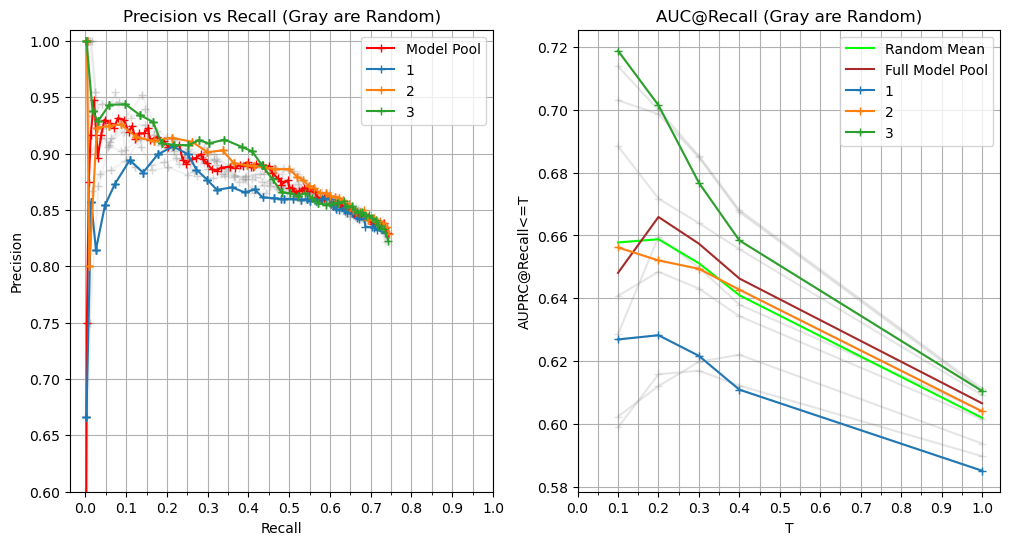

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

plot_precision_recall(precisions_df, recalls_df, mp_precision, mp_recall, best_fitness_index, ax=axs[0])
plot_aroc_at_curve(AUCTHRESHS, aucs_df, mp_auc, best_fitness_index, ax=axs[1])

### Fitness Function Diagnosis


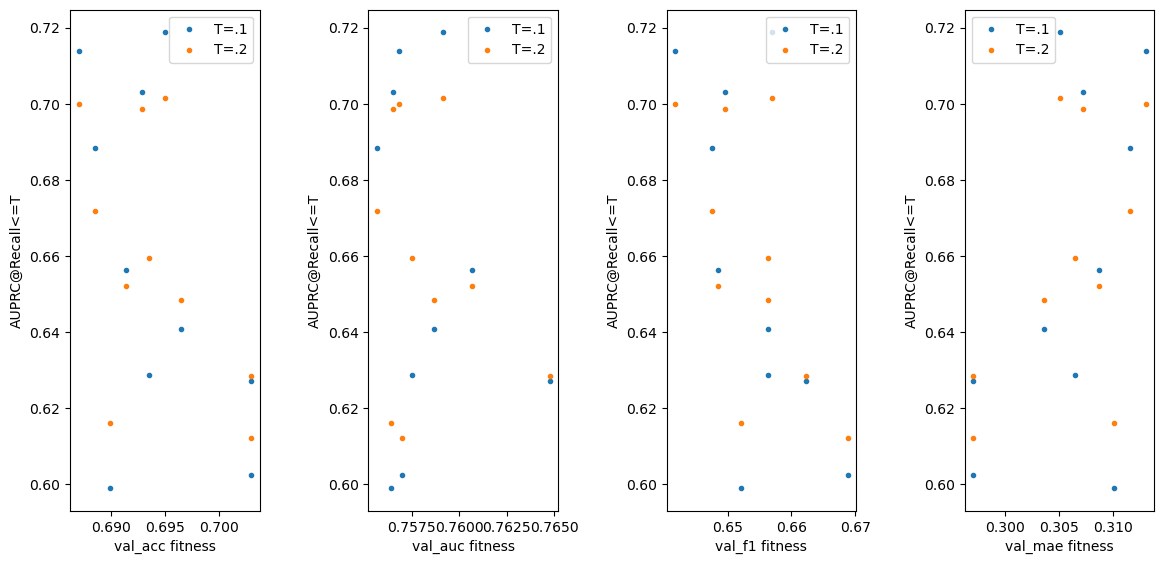

In [11]:
cols = ['val_acc', 'val_auc', 'val_f1', 'val_mae']
fig, axs = plt.subplots(1, len(cols), figsize=(12, 6))

for idx, col in enumerate(cols):
    # Plot AUC scatter for different fitness columns
    fitness_scatter(fitness_df, aucs_df, col, ax=axs[idx])
plt.tight_layout(pad=2)